# Scientific Programming - Project Work 

## Table of Contents
* [1. Libraries and Settings](#1-bullet)
* [2. Data collection](#2-bullet)
* [3. Data preprocessing](#3-bullet)
* [4. EDA (data overview, feature distribution, correlation analysis, geospatial analysis)](#4-bullet)
* [5. Data visualization (scatter plots, heat maps, bar chart)](#5-bullet)
* [6. Data insights](#6-bullet)
* [7. Jupyter notebook --footer info-- (please always provide this at the end of each submitted notebook)](#7-bullet)

## 1. Libraries and Settings <a class="anchor" id="1-bullet"></a>

In [1]:
# Required
# !pip install nltk
# !pip install bs4
# !pip install seaborn
# !pip install scipy.stats
# !pip install openpyxl

# Libraries
import os
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import sqlite3
import scipy.stats as stats
import random
import fnmatch
import openpyxl
import string
import requests
import csv
from sklearn import linear_model
import io
import folium

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Settings for seaborn
sns.set_theme(style="ticks", palette="pastel")

# Set seed
seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Current working directory
print('Current working directory:', os.getcwd())

Current working directory: C:\Users\flori\AppData\Local\Programs\Microsoft VS Code


## 2. Data collection <a class="anchor" id="2-bullet"></a>

### Asteroids - NASA

#### Neo Feed
Data from the last 7 days

In [2]:
# Connect to NASA API

import requests
import pandas as pd

# Set the API endpoint URL
url = "https://api.nasa.gov/neo/rest/v1/feed"

# Set the parameters for the API request
api_key = "96ycipvaBH52byeolyOAQPaaoEJCmLGZpzmWVwLG"
start_date = "2023-04-22"
end_date = "2023-04-29"

# Build the API request URL
request_url = f"{url}?start_date={start_date}&end_date={end_date}&api_key={api_key}"

# Send the API request and get the response
response = requests.get(request_url)

# Convert the response to JSON format
json_data = response.json()

# Extract the asteroid data from the JSON response
asteroid_data = []
for date in json_data["near_earth_objects"]:
    for asteroid in json_data["near_earth_objects"][date]:
        asteroid_data.append({
            "name": asteroid["name"],
            "diameter": asteroid["estimated_diameter"]["meters"]["estimated_diameter_max"],
            "velocity": asteroid["close_approach_data"][0]["relative_velocity"]["kilometers_per_hour"],
            "distance": asteroid["close_approach_data"][0]["miss_distance"]["kilometers"]
        })

# Convert the asteroid data to a Pandas dataframe
asteroid_df = pd.DataFrame(asteroid_data)

# Display the dataframe
print(asteroid_df)

                 name     diameter          velocity            distance
0    503871 (2000 SL)  1300.289270  77727.8591122514  19301636.067612095
1         (2011 EH17)    63.979373  54596.5599146472  16202898.191330737
2        (2011 SH189)    85.909260  21223.0597656716  52545425.832860795
3         (2015 VL64)    13.002893   27163.666504173  41479605.356460977
4          (2018 SB3)    45.085821  53219.1824680169  48916546.734900613
..                ...          ...               ...                 ...
146        (2023 DF2)   616.651765  31053.5591447596  29219717.390677825
147        (2023 HD1)    51.765448  16229.7506669628  11220623.349970089
148        (2023 HC4)    32.964006   21286.331487084   4169702.729541031
149        (2023 HW5)    44.754837  31552.5200798694    6080863.49482794
150        (2023 HM6)    93.205165  38820.5681163034  11578733.259380092

[151 rows x 4 columns]


Data from the last month (april 2023)

In [3]:
import pandas as pd
import requests

# Set the API endpoint URL
url = "https://api.nasa.gov/neo/rest/v1/feed"

# Set the parameters for the API request
api_key = "96ycipvaBH52byeolyOAQPaaoEJCmLGZpzmWVwLG"
start_date = "2023-04-01"
end_date = "2023-04-30"

# Initialize an empty list to store asteroid data
asteroid_data_month = []

# Calculate the number of days in the month
num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days + 1

# Iterate over each day and make API requests
for i in range(num_days):
    # Calculate the current date
    current_date = pd.to_datetime(start_date) + pd.DateOffset(days=i)
    
    # Convert the date to string format
    current_date_str = current_date.strftime('%Y-%m-%d')
    
    # Build the API request URL for the current date
    request_url = f"{url}?start_date={current_date_str}&end_date={current_date_str}&api_key={api_key}"
    
    # Send the API request and get the response
    response = requests.get(request_url)
    
    # Convert the response to JSON format
    json_data = response.json()
    
    # Extract the asteroid data from the JSON response
    for date in json_data["near_earth_objects"]:
        for asteroid in json_data["near_earth_objects"][date]:
            asteroid_data_month.append({
                "name": asteroid["name"],
                "diameter": asteroid["estimated_diameter"]["meters"]["estimated_diameter_max"],
                "velocity": asteroid["close_approach_data"][0]["relative_velocity"]["kilometers_per_hour"],
                "distance": asteroid["close_approach_data"][0]["miss_distance"]["kilometers"],
                "Date": date,
                "is_potentially_hazardous": asteroid["is_potentially_hazardous_asteroid"]
            })

# Convert the asteroid data to a Pandas dataframe
asteroid_df_month = pd.DataFrame(asteroid_data_month)

# Display the dataframe
print(asteroid_df_month)

                       name     diameter           velocity  \
0    69230 Hermes (1937 UB)  1853.702257    44539.989946848   
1               (2009 HA21)   401.827799  111596.4011175912   
2               (2010 LM68)   420.765360   31281.4033764623   
3               (2012 RT16)    24.776501   42234.7139745988   
4              (2015 TX144)    17.141151   28112.2720606476   
..                      ...          ...                ...   
583              (2022 UN5)    55.980913   26870.9628104036   
584              (2023 GF2)    46.562895   17235.2688366489   
585              (2023 GS2)   220.820800   64655.1639775307   
586              (2023 HN5)   209.913311   47859.8046540811   
587              (2023 HD7)    11.509063   41135.2783169998   

               distance        Date  is_potentially_hazardous  
0    35817920.538735505  2023-04-01                      True  
1    35703029.554092949  2023-04-01                      True  
2    57189551.294450013  2023-04-01                

## 3. Data preprocessing <a class="anchor" id="3-bullet"></a>

### Data types

In [4]:
# what data types are in the dataframe?
asteroid_df.dtypes

name         object
diameter    float64
velocity     object
distance     object
dtype: object

### Count and identify missing values

In [5]:
# Count missing values
print(pd.isna(asteroid_df).sum())

# Identify rows with missing values
asteroid_df[asteroid_df.isna().any(axis=1)]

name        0
diameter    0
velocity    0
distance    0
dtype: int64


,name,diameter,velocity,distance


### Count and identify duplicated values 

In [6]:
dataframes = [asteroid_df, asteroid_df_month]

for df in dataframes:
    # Count duplicated values
    duplicates_count = df.duplicated().sum()
    if duplicates_count == 0:
        print("No duplicated values in the", "last 7 days:" if df is asteroid_df else "last month:", duplicates_count)
        continue  # Skip further execution if there are no duplicates
    
    print("Number of duplicates in the dataframe:")
    print("Last 7 days:" if df is asteroid_df else "Last month:", duplicates_count)
    
    # Identify rows with duplicated values
    duplicated_rows = df[df.duplicated(subset=['name', 'diameter', 'velocity', 'distance'])]
    
    print("Rows with duplicated values:")
    print(duplicated_rows)

No duplicated values in the last 7 days: 0
No duplicated values in the last month: 0


### Convert the diameter, velocity, and distance columns to numeric data types and name to string

In [7]:
# Convert the diameter, velocity, and distance columns to numeric data types
asteroid_df["diameter"] = pd.to_numeric(asteroid_df["diameter"])
asteroid_df["velocity"] = pd.to_numeric(asteroid_df["velocity"])
asteroid_df["distance"] = pd.to_numeric(asteroid_df["distance"])
asteroid_df_month["diameter"] = pd.to_numeric(asteroid_df_month["diameter"])
asteroid_df_month["velocity"] = pd.to_numeric(asteroid_df_month["velocity"])
asteroid_df_month["distance"] = pd.to_numeric(asteroid_df_month["distance"])



In [8]:
# convert name to string
asteroid_df["name"] = asteroid_df["name"].astype(str)
asteroid_df_month["name"] = asteroid_df_month["name"].astype(str)

In [9]:
# find the five closest asteroid to Earth
closest_asteroids = asteroid_df.sort_values("distance").head(5)

# display the five closest asteroids in the right order
print(closest_asteroids[["name", "distance"]].reset_index(drop=True))

         name       distance
0  (2023 HW3)  209009.198011
1  (2023 HH3)  402349.081285
2  (2023 HX6)  449436.850921
3  (2023 HZ3)  475137.031958
4  (2023 HF4)  504112.209564


## 4. Exploratory Data Analysis (EDA) <a class="anchor" id="4-bullet"></a>

### Univariate exploratory data analysis

### Summary statistics of numeric variables

In [10]:
asteroid_df.describe()

,diameter,velocity,distance
count,151.000000,151.000000,1.510000e+02
mean,184.058208,46850.783484,2.990408e+07
std,332.812968,21971.888643,2.377497e+07
min,4.943562,6615.551081,2.090092e+05
25%,31.700693,29740.997169,6.687460e+06
50%,62.235757,43106.601809,2.735493e+07
75%,159.169660,59753.289104,5.153200e+07
max,2238.927232,154665.866310,7.376550e+07


### Statistical measures (min, max, std, mean, median, count) for selected variables

In [11]:
# diameter
print('Diameter:',
      'Count:', round(asteroid_df.diameter.count(), 1),
      'Min:', round(asteroid_df.diameter.min(), 1),
      'Max:', round(asteroid_df.diameter.max(), 1),
      'Mean:', round(asteroid_df.diameter.mean(), 1),
      'Median:', round(asteroid_df.diameter.median(), 1),
      'Std:', round(asteroid_df.diameter.std(), 1))

# velocity
print('Velocity:',
      'Count:', round(asteroid_df.velocity.count(), 1),
      'Min:', round(asteroid_df.velocity.min(), 1),
      'Max:', round(asteroid_df.velocity.max(), 1),
      'Mean:', round(asteroid_df.velocity.mean(), 1),
      'Median:', round(asteroid_df.velocity.median(), 1),
      'Std:', round(asteroid_df.velocity.std(), 1))

# distance
print('Distance:',
      'Count:', round(asteroid_df.distance.count(), 1),
      'Min:', round(asteroid_df.distance.min(), 1),
      'Max:', round(asteroid_df.distance.max(), 1),
      'Mean:', round(asteroid_df.distance.mean(), 1),
      'Median:', round(asteroid_df.distance.median(), 1),
      'Std:', round(asteroid_df.distance.std(), 1))

Diameter: Count: 151 Min: 4.9 Max: 2238.9 Mean: 184.1 Median: 62.2 Std: 332.8
Velocity: Count: 151 Min: 6615.6 Max: 154665.9 Mean: 46850.8 Median: 43106.6 Std: 21971.9
Distance: Count: 151 Min: 209009.2 Max: 73765504.0 Mean: 29904082.1 Median: 27354930.7 Std: 23774973.4


### Boxplot

<Axes: xlabel='diameter'>

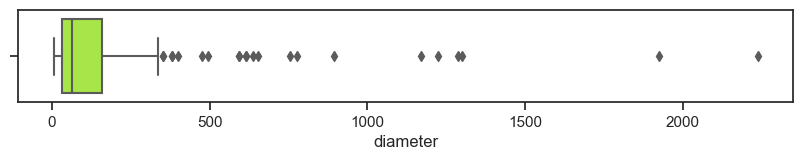

In [12]:
#Boxplot of all asteroids diameter
fig = plt.figure(figsize=(10,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=asteroid_df['diameter'], color="greenyellow")

### Histogram (matplotlib)

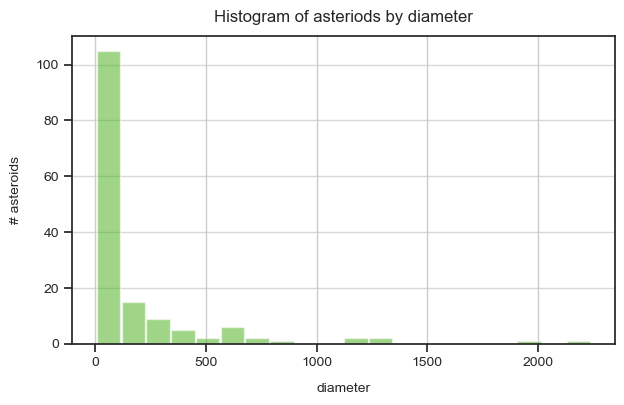

In [13]:
# Plot Histogram
fig = plt.figure( figsize=(7,4))
plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
n, bins, patches = plt.hist(x=asteroid_df['diameter'], 
                            bins=20, 
                            color='#42AD12',
                            alpha=0.5, 
                            rwidth=0.95
                   )
plt.grid(True)
plt.ticklabel_format(style='plain')
plt.grid(axis='y', alpha=0.75)

# Set labels
plt.xlabel('diameter', fontsize=10, labelpad=10)
plt.ylabel('# asteroids', fontsize=10, labelpad=10)
plt.title('Histogram of asteriods by diameter', fontsize=12, pad=10)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

### Multivariate exploratory data analysis (EDA)

### Calculate Means

In [14]:
mean_diameter = asteroid_df['diameter'].mean()
mean_velocity = asteroid_df['velocity'].mean()
mean_distance = asteroid_df['distance'].mean()

print('Mean diameter:', round(mean_diameter, 1),'m')
print('Mean velocity:', round(mean_velocity, 1),'km/h')
print('Mean distance:', round(mean_distance, 1),'km')

Mean diameter: 184.1 m
Mean velocity: 46850.8 km/h
Mean distance: 29904082.1 km


### Correlation matrix

In [15]:
corr = asteroid_df.corr()
corr

,diameter,velocity,distance
diameter,1.000000,0.322001,0.180052
velocity,0.322001,1.000000,0.338918
distance,0.180052,0.338918,1.000000


Looking at the correlation matrix, we can see that there is a positive correlation between diameter and velocity (r=0.322001). This suggests that as the diameter of the asteroid increases, its velocity also tends to increase. However, the correlation is not very strong.

There is also a positive correlation between velocity and distance (r=0.338918), which suggests that as the velocity of the asteroid increases, its distance from the Earth also tends to increase. Again, the correlation is not very strong.

Finally, there is a positive correlation between diameter and distance (r=0.180052). This suggests that as the diameter of the asteroid increases, its distance from the Earth also tends to increase. However, this correlation is weaker than the other two.

### Covariance matrix

In [16]:
cov = asteroid_df.cov()
cov

,diameter,velocity,distance
diameter,1.107645e+05,2.354644e+06,1.424680e+09
velocity,2.354644e+06,4.827639e+08,1.770441e+11
distance,1.424680e+09,1.770441e+11,5.652494e+14


Looking at the covariance matrix, we can see that the variance of diameter is smaller than the variance of velocity or distance, as expected. The covariance between diameter and velocity is positive, indicating that there is a tendency for larger asteroids to have higher velocities, but the covariance is relatively small, which might suggests that the two variables are not strongly related. The covariance between diameter and distance is also positive but again, it is relatively small.

The covariance between diameter and velocity is positive and relatively larger than the covariance between velocity and distance, which indicates a stronger relationship between diameter and velocity. However, it's difficult to compare the magnitudes of the covariances directly, especially when the variables have different units and scales.





### Compare the average velocity of the 5 smallest asteroid 

In [17]:
# find the five smallest asteroid 
size_asteroids = asteroid_df.sort_values("diameter").head(5)
                     
# display the five smallest asteroids in the right order
print(size_asteroids[["name", "diameter"]].reset_index(drop=True))

          name   diameter
0   (2021 GM1)   4.943562
1  (2010 VL65)   8.512164
2   (2023 HW3)   9.818383
3  (2021 UA12)  11.325046
4    (2022 YK)  11.482593


In [18]:
# Create pivot table
table = pd.pivot_table(size_asteroids, 
                       values='diameter',
                       columns=['name'], 
                       aggfunc=np.mean)
print(table)

name      (2010 VL65)  (2021 GM1)  (2021 UA12)  (2022 YK)  (2023 HW3)
diameter     8.512164    4.943562    11.325046  11.482593    9.818383


### ANOVA to compare the relationship between the sizes and velocity

In [19]:
import scipy.stats as stats

# Create subsets (groups)
asteroid1 = size_asteroids.loc[size_asteroids['name'] == 'size_asteroids["name"].reset_index(drop=True).values[0])']
asteroid2 = size_asteroids.loc[size_asteroids['name'] == 'size_asteroids["name"].reset_index(drop=True).values[1])']
asteroid3 = size_asteroids.loc[size_asteroids['name'] == 'size_asteroids["name"].reset_index(drop=True).values[2])']

# Filter the DataFrame based on the asteroid names
filtered_df = asteroid_df_month[asteroid_df_month['name'].isin([asteroid1, asteroid2, asteroid3])]

# Check if the filtered DataFrame has at least three data points for each asteroid
if filtered_df['name'].nunique() < 3:
 print("Insufficient data points for ANOVA")
else:
 # Retrieve the velocity values for each asteroid
 velocity1 = filtered_df.loc[filtered_df['name'] == asteroid1, 'velocity']
 velocity2 = filtered_df.loc[filtered_df['name'] == asteroid2, 'velocity']
 velocity3 = filtered_df.loc[filtered_df['name'] == asteroid3, 'velocity']

 # Perform the ANOVA test
 fvalue, pvalue = stats.f_oneway(velocity1, velocity2, velocity3)

 # Print the results
 print("ANOVA results:")
 print(f"F-value: {fvalue}")
 print(f"P-value: {pvalue}")

Insufficient data points for ANOVA


## 5. Data Visualisation <a class="anchor" id="5-bullet"></a>

### Scatterplot-matrix

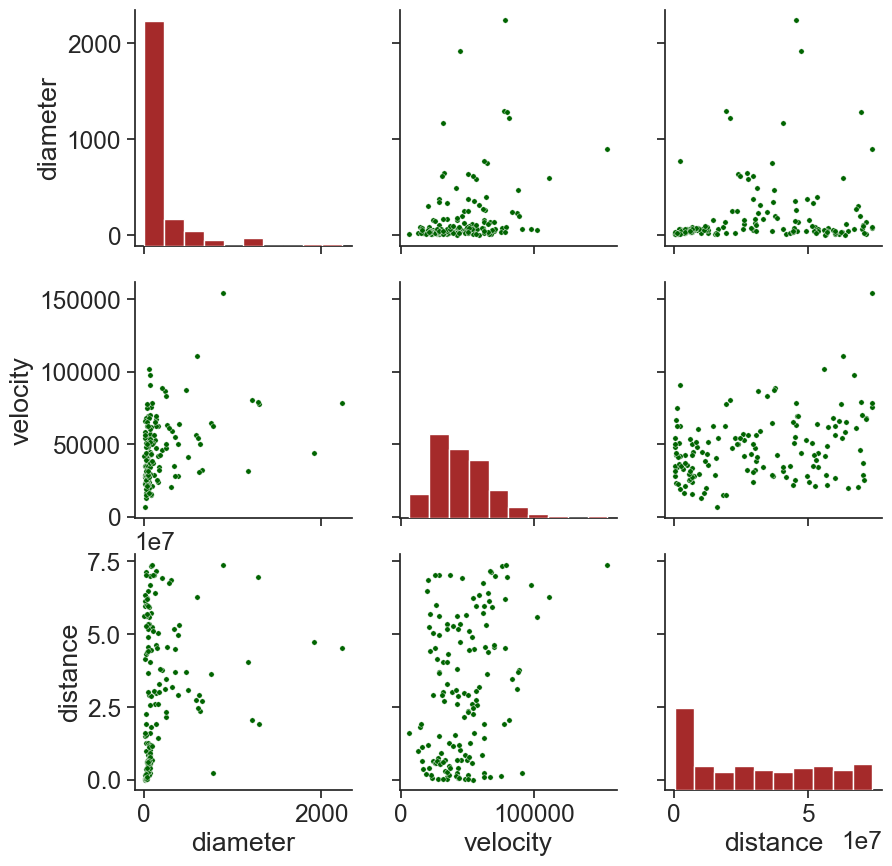

In [20]:
sns.set(style="ticks", font_scale=1.6)
g = sns.PairGrid(asteroid_df[['diameter',
                     'velocity',
                     'distance',
                     ]], 
                 height=3, 
                 aspect=1)
g.map_upper(sns.scatterplot,color='darkgreen', s=15)
g.map_lower(sns.scatterplot, color='darkgreen', s=15)
g.map_diag(plt.hist, color='brown')

### Heatmap

Correlation matrix
          diameter  velocity  distance
diameter  1.000000  0.322001  0.180052
velocity  0.322001  1.000000  0.338918
distance  0.180052  0.338918  1.000000


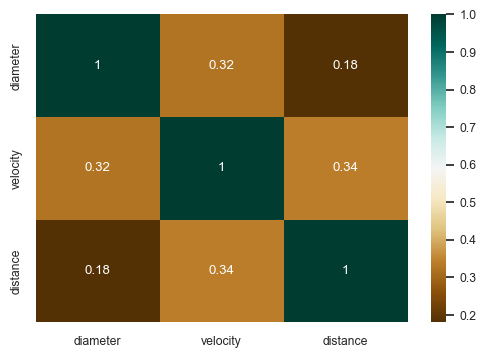

In [21]:
# Change font size of annotations
sns.set(font_scale=0.8)

# Correlation matrix
corr = asteroid_df.corr()
print('Correlation matrix')
print(corr)

# Figure
plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap="BrBG", annot=True)
plt.show()

### Scatterplot diameter vs velocity

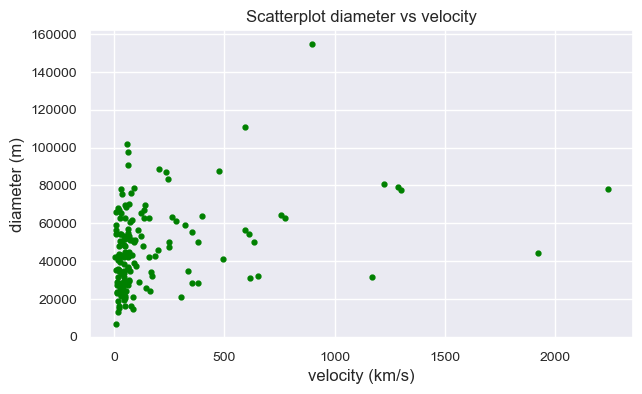

In [22]:
# Scatterplot
plt.figure(figsize=(7,4))
plt.plot(asteroid_df['diameter'], 
         asteroid_df['velocity'], 
         'o', 
         markersize=3.5,
         color="green")

# Add title and axes labels
plt.title('Scatterplot diameter vs velocity', fontsize=12)
plt.ylabel('diameter (m)', fontsize=12)
plt.xlabel('velocity (km/s)', fontsize=12)

# Set fontsize of tick labels
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10)

plt.show()

### Number of potentially hazardous asteroids in the last month <a class="anchor" id="7-bullet"></a>

The percentage of potentially hazardous asteroids in the last month was: 7.82% (46 out of 588 asteroids))


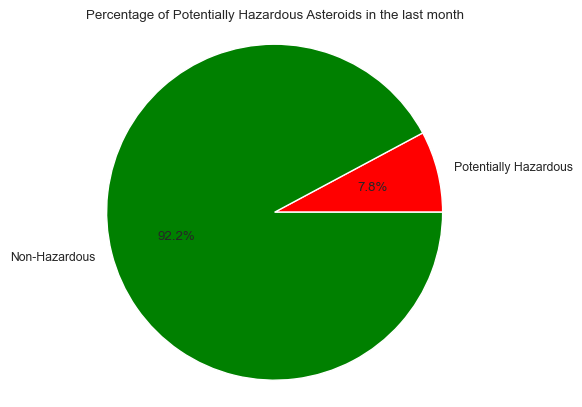

In [23]:
# Count the number of potentially hazardous asteroids in the last month
total_asteroids = len(asteroid_df_month)
potentially_hazardous_asteroids = len(asteroid_df_month[asteroid_df_month["is_potentially_hazardous"] == True])

# Calculate the percentage
percentage = (potentially_hazardous_asteroids / total_asteroids) * 100

# Print the result
print(f"The percentage of potentially hazardous asteroids in the last month was: {percentage:.2f}% ({potentially_hazardous_asteroids} out of {total_asteroids} asteroids))")

# Create a pie chart
labels = ["Potentially Hazardous", "Non-Hazardous"]
sizes = [percentage, 100 - percentage]
colors = ["red", "green"]

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Percentage of Potentially Hazardous Asteroids in the last month")
plt.axis('equal')
plt.show()

### Number of asteroids per day in the last month

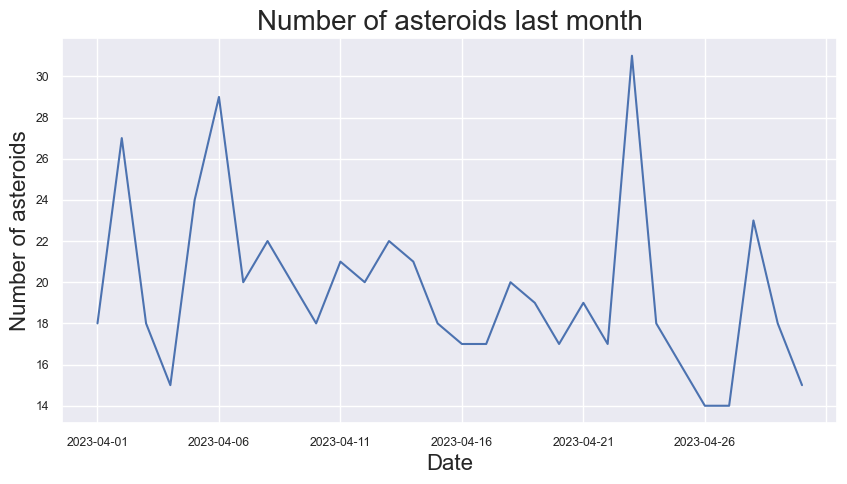

In [24]:
# Set the y-axis to display only whole numbers
from matplotlib.ticker import MaxNLocator
ax = plt.figure().gca()
ax.yaxis.set_major_locator(MaxNLocator(integer=True))

asteroid_df_month['Date'].value_counts().sort_index().plot(kind='line', figsize=(10,5))
plt.title('Number of asteroids last month', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Number of asteroids', fontsize=16)
plt.show()

## 6. Data Insights <a class="anchor" id="6-bullet"></a>

### Pearson correlation diameter vs velocity

In [25]:
# Perform Persons correlation
res = stats.pearsonr(asteroid_df['velocity'], asteroid_df['diameter'])

# Print result
print(f'Pearsons correlation coefficient (r): {res[0]:.4f}')
print(f'p-value: {res[1]:.4f}')

Pearsons correlation coefficient (r): 0.3220
p-value: 0.0001


The correlation coefficient (r) of 0.3220 suggests a weak positive correlation between the two variables. It means that as one variable increases, the other variable tends to increase as well, but the relationship is not very strong.

In this case, the p-value is 0.0001, which is less than 0.05, indicating that the correlation is statistically significant and reject the null hypothesis that there is no correlation between the two variables, concluding that there is evidence of a correlation. This means that there is a low probability that the correlation coefficient of 0.3469 occurred by chance.

### 7. Jupyter notebook --footer info-- <a class="anchor" id="7-bullet"></a>

In [26]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
NT
Windows | 10
Datetime: 2023-05-26 21:37:16
Python Version: 3.10.9
-----------------------------------
